<a href="https://colab.research.google.com/github/Davidportlouis/horse_vs_human_classifier/blob/master/horses_vs_humans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import numpy as np
from PIL import Image
from torch import nn,optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms,datasets,models
from torch.utils.data.sampler import SubsetRandomSampler
from helper import plot_batch,train,test,predict,predict_image

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O horse-or-human.zip
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O validation-horse-or-human.zip 
!unzip "horse-or-human.zip" -d "./data/train"
!unzip "validation-horse-or-human.zip" -d "./data/valid/"

In [7]:
train_transform = transforms.Compose([
  transforms.Resize(229),
  transforms.RandomHorizontalFlip(),
  transforms.RandomVerticalFlip(),
  transforms.RandomRotation(45),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485,0.456,0.406],
                       std=[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
  transforms.Resize(229),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485,0.456,0.406],
                       std=[0.229,0.224,0.225])
])

train_data = datasets.ImageFolder("./data/train",transform=train_transform)
test_data = datasets.ImageFolder("./data/valid",transform=test_transform)

train_len = len(train_data)
idx = list(range(train_len))
np.random.shuffle(idx)
split = int(np.floor(0.2 * train_len))
valid_idx,train_idx = idx[:split],idx[split:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data,batch_size=20,sampler=train_sampler)
valid_loader = DataLoader(train_data,batch_size=20,sampler=valid_sampler)
test_loader = DataLoader(test_data,batch_size=20,shuffle=True)
classes = train_data.classes

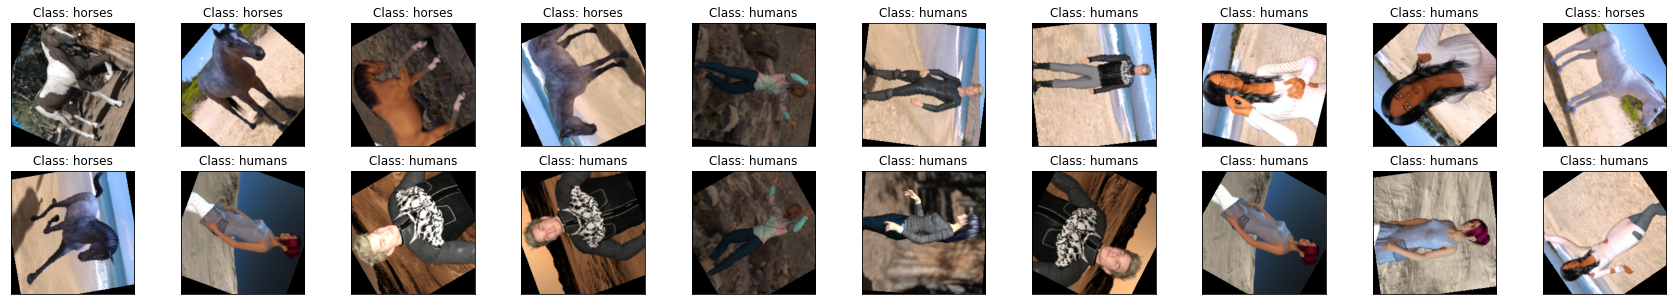

In [8]:
train_images,train_labels = next(iter(train_loader))
plot_batch(train_images,classes,train_labels,normalize=True)

In [9]:
model = models.inception_v3(pretrained=True,aux_logits=False)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


In [18]:
for params in model.parameters():
  params.require_grad = False

In [32]:
fc = nn.Sequential(
    nn.Linear(2048,1024),
    nn.ReLU(),
    nn.Linear(1024,2)
)
model.fc = fc

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(),lr=0.01)

In [35]:
train_losses,valid_losses = train(model,train_loader,valid_loader,optimizer,criterion,1,device)

epoch: 1/1 trainloss: 2.26834 validloss: 0.15510 time: 335.197 sec
Loss decresed: inf -> 0.15510


In [ ]:
plt.plot(train_losses,label="training loss")
plt.plot(valid_losses,label="validation loss")
plt.title("training vs validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [37]:
state_dict = torch.load("model_weights.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [38]:
test(model,test_loader,optimizer,criterion,device)

testloss: 0.607567 accuracy: 0.642


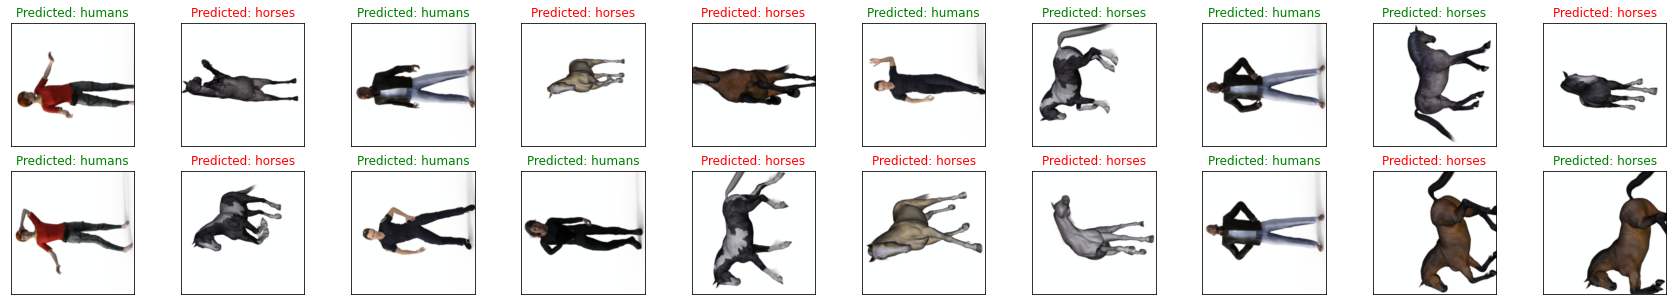

In [39]:
test_images,test_labels = next(iter(test_loader))
predict(test_images,classes,test_labels,model,device)

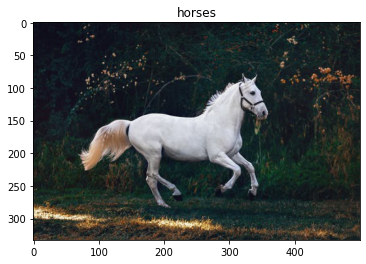

In [ ]:
predict_image("t1_horse.jpeg",model,test_transform,device,classes)

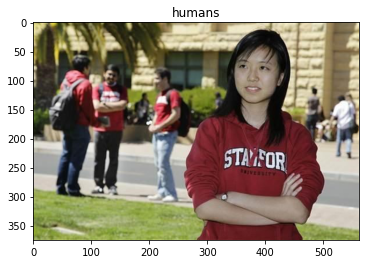

In [ ]:
predict_image("t2_human.jpg",model,test_transform,device,classes)